In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb
import joblib
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
df = pd.read_csv('selected_df.csv')

In [3]:
df.head()

,Merchant_category,Transaction_amount,Gender,zip,Job,trans_num,trans_hour,cust_age_groups,amount_to_avg_ratio,Is_fraud
0,misc_net,4.97,F,28654,"Psychologist, counselling",0b242abb623afc578575680df30655b9,0,30-40,0.055587,0
1,grocery_pos,107.23,F,99160,Special educational needs teacher,1f76529f8574734946361c461b024d99,0,40-50,1.912154,0
2,entertainment,220.11,M,83252,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,0,50-60,3.147834,0
3,gas_transport,45.00,M,59632,Patent attorney,6b849c168bdad6f867558c3793159a81,0,50-60,0.561868,0
4,misc_pos,41.96,M,24433,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,0,30-40,0.440104,0


In [4]:
df.isnull().sum()

Merchant_category      0
Transaction_amount     0
Gender                 0
zip                    0
Job                    0
trans_num              0
trans_hour             0
cust_age_groups        0
amount_to_avg_ratio    0
Is_fraud               0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Merchant_category    object 
 1   Transaction_amount   float64
 2   Gender               object 
 3   zip                  int64  
 4   Job                  object 
 5   trans_num            object 
 6   trans_hour           int64  
 7   cust_age_groups      object 
 8   amount_to_avg_ratio  float64
 9   Is_fraud             int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 141.3+ MB


🎯 Goal:
Track each transaction (with trans_num and Transaction_amount) linked to the model's prediction outcome, so you can:

Estimate losses due to undetected frauds (false negatives)

Estimate costs of wrongly flagged legitimate transactions (false positives)

Prioritize actions based on financial impact, not just accuracy

In [17]:
X = df.drop(columns=['Is_fraud'])  # Features
y = df['Is_fraud']  # Target variable

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1296675, 9), (555719, 9), (1296675,), (555719,))

In [19]:
# storing the transaction numbers from both train and test data into separate dataframes respectively
txn_train = pd.DataFrame(X_train[['trans_num','Transaction_amount']].values, columns = ['txn_num','amt'])
txn_test = pd.DataFrame(X_test[['trans_num','Transaction_amount']].values, columns = ['txn_num','amt'])

# check
txn_train

,txn_num,amt
0,9006071a5e8236bb033f9b2ca5e90d87,62.29
1,ac2d8ed507b62698aa5c344f1c1f9c88,5.56
2,cd4a1a4fe9a5de2e49fd1f9ffdd7d956,9.9
3,2cb6aeed31669f676c1789e3d44f6553,6.29
4,12881b494567a8f8eaee4db02b73eedc,20.71
...,...,...
1296670,444d47d2786e8b0b345a486baa47f510,19.13
1296671,a041ad4ddb4532d9b6147b94259dd9ea,74.15
1296672,93c58684304726579f25df4d844e0c7c,116.07
1296673,8f00350564ae8d24c6a08d715325d0be,2.52


In [20]:
txn_test

,txn_num,amt
0,4f766b89f4a048905868115a335fe7a0,112.65
1,79255478c6f35c281418bb41ecb08e66,5.11
2,01efa2e78fc95bba74bf38145bb1de86,7.74
3,0ed04256bc61306478786e4ea3170b4d,7.53
4,0e34606b61baef173b7eebdeaf038dcf,98.67
...,...,...
555714,95c1ccbeb146ad868f13ed30b384dfbc,3.55
555715,ddea0008dd1478215074cf351e3fabab,72.5
555716,cef6ed3fbdb0c7aac9f4e2f48fddc765,18.79
555717,fc31b7df41aa42f8f5ecefbafe3ba7f8,1.1


In [21]:
txn_train['is_fraud'] = y_train.values
fraud_txns_train = txn_train[txn_train['is_fraud'] == 1]
train_fraud_loss = fraud_txns_train['amt'].sum()
print(f"💸 Train total fraud loss without a model: ${train_fraud_loss:.2f}")

# Test set fraud loss
txn_test['is_fraud'] = y_test.values
fraud_txns_test = txn_test[txn_test['is_fraud'] == 1]
test_fraud_loss = fraud_txns_test['amt'].sum()
print(f"💸 Test total fraud loss without a model: ${test_fraud_loss:.2f}")

💸 Train total fraud loss without a model: $3574110.01
💸 Test total fraud loss without a model: $1547303.28


In [22]:
df.head()

,Merchant_category,Transaction_amount,Gender,zip,Job,trans_num,trans_hour,cust_age_groups,amount_to_avg_ratio,Is_fraud
0,misc_net,4.97,F,28654,"Psychologist, counselling",0b242abb623afc578575680df30655b9,0,30-40,0.055587,0
1,grocery_pos,107.23,F,99160,Special educational needs teacher,1f76529f8574734946361c461b024d99,0,40-50,1.912154,0
2,entertainment,220.11,M,83252,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,0,50-60,3.147834,0
3,gas_transport,45.00,M,59632,Patent attorney,6b849c168bdad6f867558c3793159a81,0,50-60,0.561868,0
4,misc_pos,41.96,M,24433,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,0,30-40,0.440104,0


In [23]:
#drop trans_num 
df.drop('trans_num',axis = 1, inplace = True)

In [24]:
#loading the label encoders
le_gender=joblib.load('encoders/le_gender.pkl')
le_merchant_category=joblib.load('encoders/le_merchant_category.pkl')
le_cust_age_groups=joblib.load('encoders/le_cust_age_groups.pkl')
le_Job=joblib.load('encoders/le_Job.pkl')

In [25]:
df['Gender'] = le_gender.fit_transform(df['Gender'])
df['Merchant_category'] = le_merchant_category.fit_transform(df['Merchant_category'])
df['Job'] = le_Job.fit_transform(df['Job'])
df['cust_age_groups'] = le_cust_age_groups.fit_transform(df['cust_age_groups'])

In [111]:
merchant_category_classes = list(le_merchant_category.classes_)

merchant_category_mapping = {category: idx for idx, category in enumerate(merchant_category_classes)}

print("Merchant Category to Label Mapping:")
for category, label in merchant_category_mapping.items():
    print(f"{category} -> {label}")

Merchant Category to Label Mapping:
entertainment -> 0
food_dining -> 1
gas_transport -> 2
grocery_net -> 3
grocery_pos -> 4
health_fitness -> 5
home -> 6
kids_pets -> 7
misc_net -> 8
misc_pos -> 9
personal_care -> 10
shopping_net -> 11
shopping_pos -> 12
travel -> 13


In [26]:
df.head()

,Merchant_category,Transaction_amount,Gender,zip,Job,trans_hour,cust_age_groups,amount_to_avg_ratio,Is_fraud
0,8,4.97,0,28654,372,0,2,0.055587,0
1,4,107.23,0,99160,431,0,3,1.912154,0
2,0,220.11,1,83252,308,0,4,3.147834,0
3,2,45.00,1,59632,330,0,4,0.561868,0
4,9,41.96,1,24433,116,0,2,0.440104,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Merchant_category    int64  
 1   Transaction_amount   float64
 2   Gender               int64  
 3   zip                  int64  
 4   Job                  int64  
 5   trans_hour           int64  
 6   cust_age_groups      int64  
 7   amount_to_avg_ratio  float64
 8   Is_fraud             int64  
dtypes: float64(2), int64(7)
memory usage: 127.2 MB


## 🔄 Train-Test split and preparing the data for the models 

In [28]:
X = df.drop(columns=['Is_fraud'])  # Features
y = df['Is_fraud']  # Target variable

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1296675, 8), (555719, 8), (1296675,), (555719,))

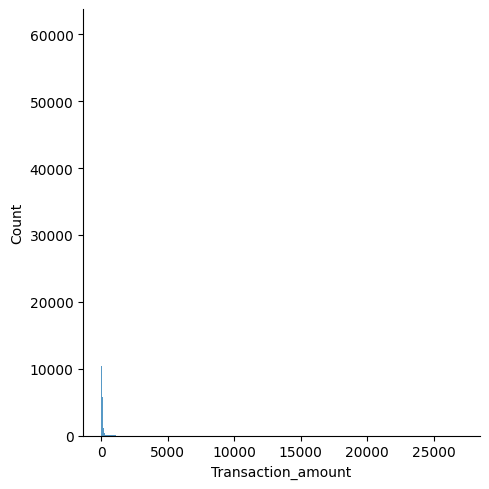

In [30]:
 #let's see how the numerical columns are distributed
sns.displot(X_train['Transaction_amount'])

# doing log transformation to Transaction_amount to make it more normally distributed and avoid  skewness

In [31]:
# applying log transformations
X_train['Transaction_amount'] = np.log(X_train['Transaction_amount']+1)
X_test['Transaction_amount'] = np.log(X_test['Transaction_amount']+1)

C:\Users\Youssef Abdel Khaleq\AppData\Local\Temp\ipykernel_10456\2792083266.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train['Transaction_amount'])
C:\Users\Youssef Abdel Khaleq\AppData\Local\Temp\ipykernel_10456\2792083266.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_test['T

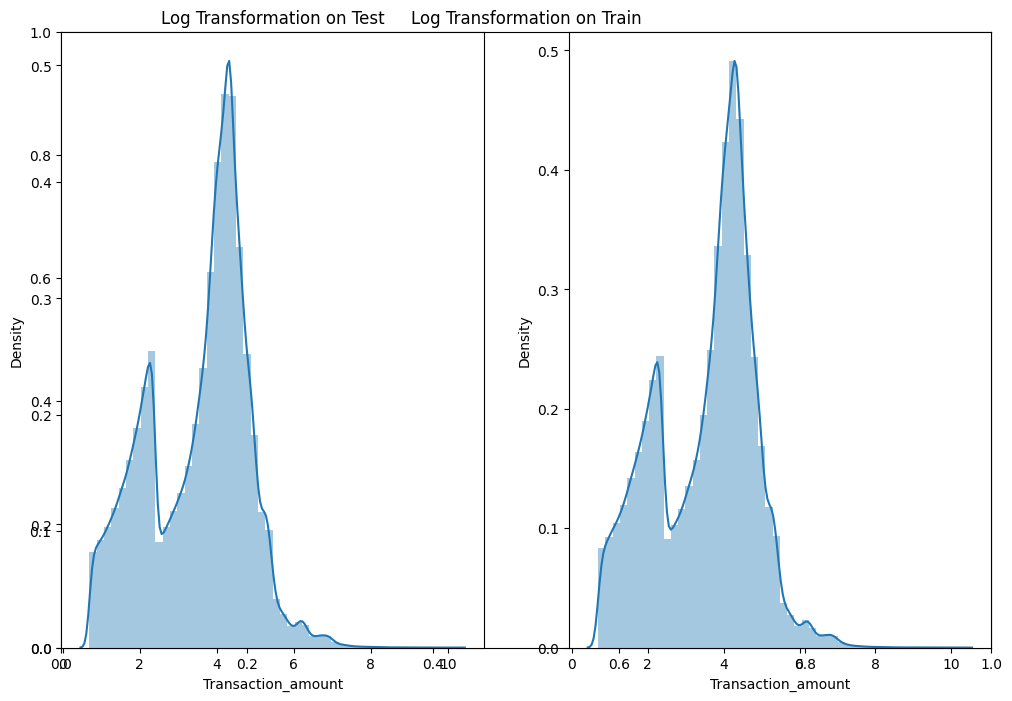

In [32]:
plt.figure(figsize=(12, 8))
plt.title('Log Transformation on Train')
plt.subplot(1, 2, 1)
sns.distplot(X_train['Transaction_amount'])

plt.title('Log Transformation on Test')
plt.subplot(1, 2, 2)
sns.distplot(X_test['Transaction_amount'])
plt.show()

In [33]:
X_train.head()

,Merchant_category,Transaction_amount,Gender,zip,Job,trans_hour,cust_age_groups,amount_to_avg_ratio
1606730,2,4.147727,0,79539,489,4,2,1.129694
762160,9,1.880991,1,35049,17,18,3,0.093245
1446803,12,2.388763,0,67216,464,10,7,0.155003
172336,10,1.986504,1,14425,115,17,5,0.088731
1364867,0,3.077773,0,26339,74,14,4,0.363167


## 🤖 Model Selection and evaluation

# scaleing phase

In [34]:
#loading the scaler
from sklearn.preprocessing import StandardScaler

In [35]:
scaler = StandardScaler()

# Fit on X_train, transform both X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [37]:
#check distribution for target to get the scale pos weight
df['Is_fraud'].value_counts()

Is_fraud
0    1842743
1       9651
Name: count, dtype: int64

### ✅ Why We Used Class Balancing in Our Models

In our dataset, the classes were imbalanced — fraudulent transactions were much fewer than normal ones. This can cause models to always predict the majority class and ignore the minority (fraud), leading to poor recall.

Instead of using oversampling or undersampling, we applied class balancing **inside the models** to handle this issue more effectively.

---

### ❌ Why Not Oversampling or Undersampling?

- **Oversampling (e.g., SMOTE)** adds fake/synthetic data → can cause overfitting.
- **Undersampling** removes real data → may lose valuable information.
  
Both methods also change the original data distribution, which we wanted to avoid.

---

  

In [42]:
#scale_pos_weight = number of negative samples / number of positive samples
scale_pos_weight = 1842743 / 9651 
print(round(scale_pos_weight))

191


In [38]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight ='balanced'),
    'XGBoost': xgb.XGBClassifier(scale_pos_weight='191'),
    'LightGBM': lgb.LGBMClassifier(is_unbalance=True)
}
results = {}

In [39]:
from tqdm import tqdm

In [41]:
ModelName=[]
ModelAccuracy=[]
for name, model in tqdm(models.items()):
    model.fit(X_train_scaled, y_train)
    ModelName.append(name)
    y_pred = model.predict(X_test_scaled)
    ModelAccuracy.append([
         accuracy_score(y_test, y_pred),
         precision_score(y_test, y_pred),
         recall_score(y_test, y_pred),
         f1_score(y_test,y_pred)
         ])
ModelAccuracy=pd.DataFrame(ModelAccuracy,index=ModelName,columns=['Accuracy','Precision','Recall','F1 Score'])
ModelAccuracy

 80%|████████  | 4/5 [08:00<02:11, 131.60s/it]

[LightGBM] [Info] Number of positive: 6756, number of negative: 1289919
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 1296675, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005210 -> initscore=-5.251904
[LightGBM] [Info] Start training from score -5.251904


100%|██████████| 5/5 [08:06<00:00, 97.36s/it] 


,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.921007,0.046116,0.719516,0.086676
Decision Tree,0.998107,0.834969,0.793437,0.813673
Random Forest,0.998676,0.954526,0.783074,0.860342
XGBoost,0.990706,0.354711,0.957168,0.517605
LightGBM,0.971038,0.146567,0.945423,0.253790


🌉 Why Choose Random Forest?
Highest Overall Accuracy (99.86%)
➤ This means the model rarely makes mistakes, and that’s critical for a fraud detection system.

Top Precision (95.45%)
➤ When the model flags a transaction as fraud, it's correct 95% of the time – reducing false alarms.

Strong Recall (78.31%)
➤ It still captures the majority of fraudulent cases. While not the highest (XGBoost does better here), RF offers a solid balance between precision and recall.

Best F1 Score (86.03%)
➤ F1 score is the most balanced metric, and Random Forest has the best score, showing it’s reliable and balanced.

# Random Forest Classifier

In [43]:
rf = RandomForestClassifier(class_weight = 'balanced')

In [44]:
# fitting on the training data
rf.fit(X_train_scaled,y_train)

# predictions on the training data
y_pred_train_rf = rf.predict(X_train_scaled)

# predictions on the test data
y_pred_test_rf = rf.predict(X_test_scaled)

In [45]:
# check confusion matrix on both train and test data

## TN FP
## FN TP
cm_train = confusion_matrix(y_train,y_pred_train_rf)
cm_test = confusion_matrix(y_test,y_pred_test_rf)
print('Training data:',cm_train)
print()
print('Testing data:', cm_test)

Training data: [[1289918       1]
 [      3    6753]]

Testing data: [[552712    112]
 [   639   2256]]


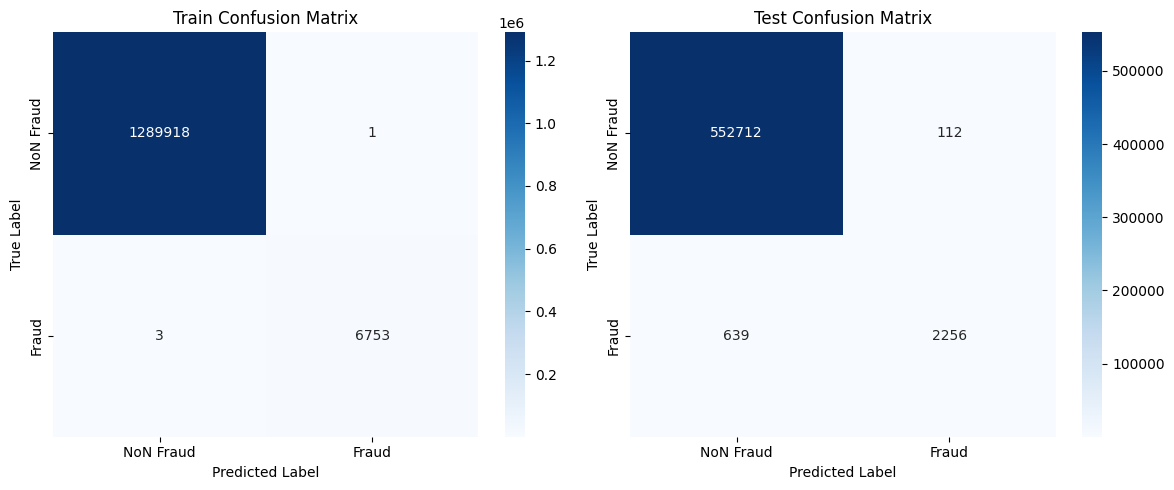

In [47]:
plt.figure(figsize=(12, 5))

# Confusion Matrix - Train
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NoN Fraud", "Fraud"],
            yticklabels=["NoN Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Train Confusion Matrix")

# Confusion Matrix - Test
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NoN Fraud", "Fraud"],
            yticklabels=["NoN Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")

plt.tight_layout()
plt.show()

In [48]:

# check recall scores on train data
print(f'Recall score of the model on train data: {cm_train[1][1]/(cm_train[1][1]+cm_train[1][0])}')

Recall score of the model on train data: 0.9995559502664298


In [49]:
precision_train = cm_train[1][1] / (cm_train[1][1] + cm_train[0][1])  # TP / (TP + FP)
recall_train = cm_train[1][1] / (cm_train[1][1] + cm_train[1][0])  # TP / (TP + FN)
f1_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)
accuracy_train = (cm_train[0][0] + cm_train[1][1]) / cm_train.sum()  # (TP + TN) / Total
print("=== Training Metrics ===")
print(f"Precision: {precision_train:.4f}")
print(f"Recall:    {recall_train:.4f}")
print(f"F1 Score:  {f1_train:.4f}")
print(f"Accuracy:  {accuracy_train:.4f}")
print()

=== Training Metrics ===
Precision: 0.9999
Recall:    0.9996
F1 Score:  0.9997
Accuracy:  1.0000



In [50]:
# check recall scores on test data
print(f'Recall score of the model on test data: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0])}')

Recall score of the model on test data: 0.7792746113989637


In [51]:
precision_test = cm_test[1][1] / (cm_test[1][1] + cm_test[0][1])  # TP / (TP + FP)
recall_test = cm_test[1][1] / (cm_test[1][1] + cm_test[1][0])  # TP / (TP + FN)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
accuracy_test = (cm_test[0][0] + cm_test[1][1]) / cm_test.sum()  # (TP + TN) / Total
print("=== Testing Metrics ===")
print(f"Precision: {precision_test:.4f}")
print(f"Recall:    {recall_test:.4f}")
print(f"F1 Score:  {f1_test:.4f}")
print(f"Accuracy:  {accuracy_test:.4f}")

=== Testing Metrics ===
Precision: 0.9527
Recall:    0.7793
F1 Score:  0.8573
Accuracy:  0.9986


# there is overfitting

In [52]:
# get the parameters of the model
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [54]:
rf = RandomForestClassifier(class_weight = 'balanced')
params = {'n_estimators':[5,10,20,40,80,100,200],
          'criterion':['gini','entropy','log_loss'],
          'max_depth':[2,5,10,20],
          'min_samples_split':[2,4,8,12],
          'min_samples_leaf':[2,4,6,8,10],
          'oob_score': [True]}
#randomized search cv 
rcv = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 10, scoring = 'recall', cv = 5, verbose=5, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [2, 5, 10, 20],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 4, 8, 12],
                                        'n_estimators': [5, 10, 20, 40, 80, 100,
                                                         200],
                                        'oob_score': [True]},
                   random_state=42, return_train_score=True, scoring='recall',
                   verbose=5)

In [57]:
cv_results = pd.DataFrame(rcv.cv_results_)

cv_results_display = cv_results[[
    'params',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]].sort_values(by='rank_test_score')


print(cv_results_display)

                                              params  mean_test_score  \
2  {'oob_score': True, 'n_estimators': 200, 'min_...         0.945680   
1  {'oob_score': True, 'n_estimators': 40, 'min_s...         0.943608   
3  {'oob_score': True, 'n_estimators': 200, 'min_...         0.900387   
5  {'oob_score': True, 'n_estimators': 40, 'min_s...         0.888694   
7  {'oob_score': True, 'n_estimators': 5, 'min_sa...         0.872561   
9  {'oob_score': True, 'n_estimators': 80, 'min_s...         0.864863   
6  {'oob_score': True, 'n_estimators': 10, 'min_s...         0.855095   
4  {'oob_score': True, 'n_estimators': 40, 'min_s...         0.753551   
8  {'oob_score': True, 'n_estimators': 20, 'min_s...         0.751184   
0  {'oob_score': True, 'n_estimators': 200, 'min_...         0.751037   

   std_test_score  rank_test_score  
2        0.006150                1  
1        0.007523                2  
3        0.007827                3  
5        0.010703                4  
7        0.

In [58]:
# best estimator
rcv.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=200, oob_score=True)

In [59]:
# best score
rcv.best_score_

np.float64(0.9456796193045696)

In [60]:
# let's re build random forest model
rf = rcv.best_estimator_

# fitting on train data
rf.fit(X_train_scaled,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=200, oob_score=True)

In [61]:
# predictions on train data
y_train_pred_rf = rf.predict(X_train_scaled)

# predictions on test data
y_test_pred_rf = rf.predict(X_test_scaled)

In [62]:
print("calssification report on train data")
print(classification_report(y_train, y_train_pred_rf))
print("calssification report on test data")
print(classification_report(y_test, y_test_pred_rf))

calssification report on train data
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1289919
           1       0.26      0.97      0.41      6756

    accuracy                           0.99   1296675
   macro avg       0.63      0.98      0.70   1296675
weighted avg       1.00      0.99      0.99   1296675

calssification report on test data
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552824
           1       0.25      0.95      0.40      2895

    accuracy                           0.99    555719
   macro avg       0.63      0.97      0.70    555719
weighted avg       1.00      0.99      0.99    555719



In [63]:
# check confusion matrix on both train and test data
## TN FP
## FN TP
cm_train = confusion_matrix(y_train,y_train_pred_rf)
cm_test = confusion_matrix(y_test,y_test_pred_rf)
print('Training data:',cm_train)
print()
print('Testing data:', cm_test)

Training data: [[1271261   18658]
 [    200    6556]]

Testing data: [[544662   8162]
 [   148   2747]]


In [64]:
# check recall scores on train data
print(f'Recall score of the model on train data: {cm_train[1][1]/(cm_train[1][1]+cm_train[1][0])}')
# check recall scores on test data
print(f'Recall score of the model on test data: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0])}')

Recall score of the model on train data: 0.970396684428656
Recall score of the model on test data: 0.9488773747841105


In [65]:
feature_names = X.columns
feature_imp_rf = pd.DataFrame({
    'feature': feature_names,
    'feature_importance_%': rf.feature_importances_ * 100
})


In [66]:
# check
feature_imp_rf = feature_imp_rf.sort_values(by='feature_importance_%', ascending=False).reset_index(drop=True)
feature_imp_rf

,feature,feature_importance_%
0,Transaction_amount,41.366263
1,amount_to_avg_ratio,26.850606
2,trans_hour,17.069666
3,Merchant_category,11.440915
4,cust_age_groups,1.382871
5,zip,0.730096
6,Job,0.660204
7,Gender,0.499378


C:\Users\Youssef Abdel Khaleq\AppData\Local\Temp\ipykernel_10456\98271040.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


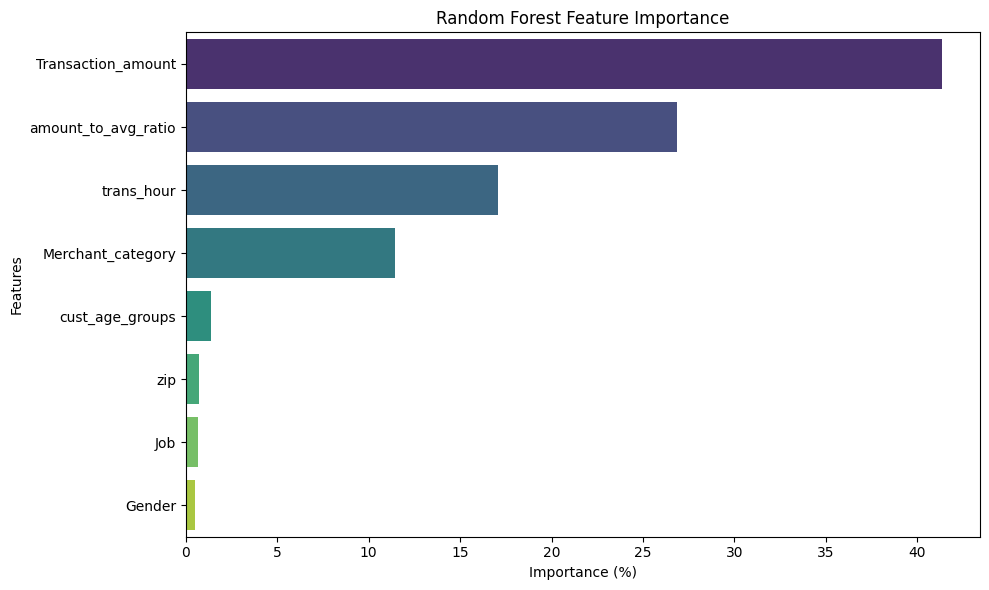

In [67]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_imp_rf,
    x='feature_importance_%',
    y='feature',
    palette='viridis'
)

plt.title('Random Forest Feature Importance')
plt.xlabel('Importance (%)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Inferences: As per the random forest model, the top 4 significant features are Transaction_amount, Transaction_hour and Merchant category,zip code.

In [68]:
selected_features = ['Transaction_amount', 'trans_hour', 'Merchant_category','zip']

In [69]:

X = df[selected_features]  # Features
y = df['Is_fraud']  # Target variable

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [70]:
final_scaler = StandardScaler()
# Fit on X_train, transform both X_train and X_test
X_train_scaled = final_scaler.fit_transform(X_train)
X_test_scaled = final_scaler.transform(X_test)

In [73]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [74]:
X_train_scaled.head()

,Transaction_amount,trans_hour,Merchant_category,zip
1606730,-0.049452,-1.292328,-1.080006,1.141957
762160,-0.411866,0.761943,0.708529,-0.512232
1446803,-0.384140,-0.411926,1.475044,0.683774
172336,-0.407203,0.615209,0.964034,-1.279057
1364867,-0.315082,0.175008,-1.591016,-0.836080


In [75]:
joblib.dump(final_scaler, 'scaler/final_scaler.pkl')

['scaler/final_scaler.pkl']

In [76]:
# initializing random forest model
rf = rcv.best_estimator_

# fitting
rf.fit(X_train_scaled,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=200, oob_score=True)

In [89]:
# predictions on train data
y_train_pred_rf = rf.predict(X_train_scaled)

# predictions on test data
y_test_pred_rf = rf.predict(X_test_scaled)

In [90]:
print("calssification report on train data")
print(classification_report(y_train, y_train_pred_rf))
print("calssification report on test data")
print(classification_report(y_test, y_test_pred_rf))

calssification report on train data
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1289919
           1       0.25      0.97      0.39      6756

    accuracy                           0.98   1296675
   macro avg       0.62      0.98      0.69   1296675
weighted avg       1.00      0.98      0.99   1296675

calssification report on test data
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    552824
           1       0.24      0.95      0.38      2895

    accuracy                           0.98    555719
   macro avg       0.62      0.97      0.69    555719
weighted avg       1.00      0.98      0.99    555719



In [91]:
# check confusion matrix on both train and test data
## TN FP
## FN TP
cm_train = confusion_matrix(y_train,y_train_pred_rf)
cm_test = confusion_matrix(y_test,y_test_pred_rf)
print('Training data:',cm_train)
print()
print('Testing data:', cm_test)

Training data: [[1269845   20074]
 [    196    6560]]

Testing data: [[543994   8830]
 [   140   2755]]


In [80]:
# check recall scores on train data
print(f'Recall score of the model on train data: {cm_train[1][1]/(cm_train[1][1]+cm_train[1][0])}')
# check recall scores on test data
print(f'Recall score of the model on test data: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0])}')

Recall score of the model on train data: 0.9709887507400828
Recall score of the model on test data: 0.9516407599309153


In [81]:
from sklearn.metrics import roc_curve, roc_auc_score

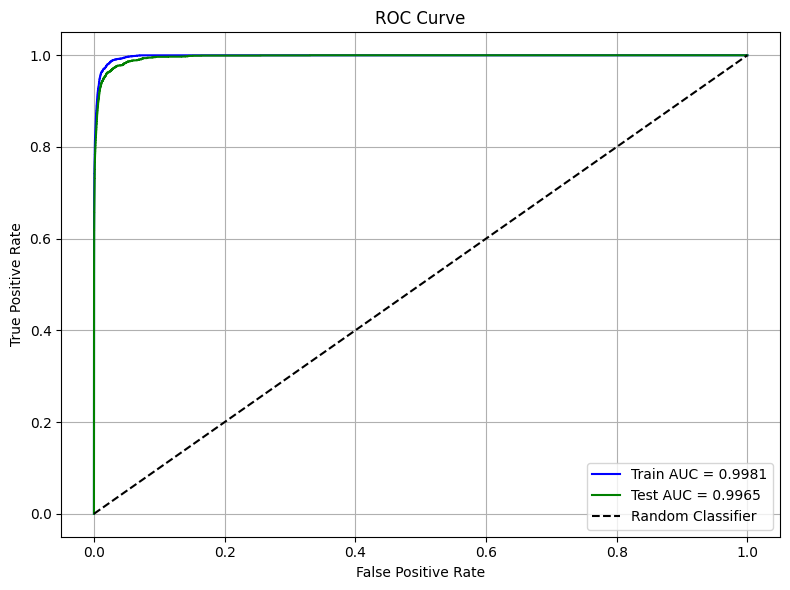

In [84]:
y_train_probs = rf.predict_proba(X_train_scaled)[:, 1]
y_test_probs = rf.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC score
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

auc_train = roc_auc_score(y_train, y_train_probs)
auc_test = roc_auc_score(y_test, y_test_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.4f}', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.4f}', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Train AUC Score: 0.9981

Test AUC Score: 0.9965

AUC close to 1.0 indicates that the model is very good at distinguishing between classes.

The gap between train and test is very small, suggesting no significant overfitting.

The ROC curve lies well above the random line (black dashed), showing strong classifier performance.




In [85]:
# feature importances
feature_imp_rf = pd.DataFrame(index = X.columns, data = rf.feature_importances_*100, columns = ['feature_importance_%'])

# check
feature_imp_rf

,feature_importance_%
Transaction_amount,66.788063
trans_hour,18.068454
Merchant_category,14.168002
zip,0.975480


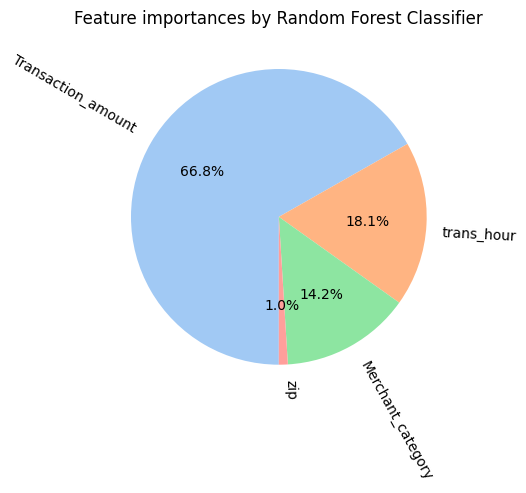

In [88]:
plt.title('Feature importances by Random Forest Classifier')
plt.pie(x = feature_imp_rf['feature_importance_%'], labels = feature_imp_rf.index, rotatelabels = True, startangle = 270, counterclock = False, autopct='%1.1f%%', colors = sns.color_palette('pastel'))
plt.show()

### 🔍 Conclusion

In this fraud detection problem, relying on **accuracy alone** is misleading due to the strong **class imbalance** in the dataset.

Since fraud is the rare and more critical class, our main goal was to **maximize Recall** — to reduce the number of **False Negatives**, which are the most dangerous (fraudulent transactions predicted as normal).

From the classification report, we achieved a **Recall of 95%**, which means we successfully caught most fraudulent transactions. However, the **Precision dropped to 24%**, showing that a large portion of the flagged frauds were actually normal transactions (False Positives).

This drop in Precision is expected in imbalanced problems:  
Even a small percentage of wrong predictions on the majority class (normal transactions) results in a **large absolute number of false positives**, which pulls Precision down.

---

### 🔧 Key Takeaways:
- **High Recall (95%)** ensures frauds are rarely missed.
- **Low Precision (24%)** means many alerts may be false alarms.
- The imbalance makes it hard to optimize both metrics at once.
- The best approach would be to **understand the cost** of False Positives vs. False Negatives — so we can tune the model based on the actual business impact.

This helps ensure the model is both statistically sound and aligned with real-world risk management goals.

The best approach to this problem would be having a way to calculate the mean cost of each false positive and false negative. This way, we could approach this tradeoff with better understanding of how much false positives and false negatives costs for the company.

In [93]:
# creating a dataframe
rf_results = pd.DataFrame()

In [94]:
rf_results['txn_num'] = pd.concat([txn_train,txn_test])['txn_num'].values
rf_results['amt'] = pd.concat([txn_train,txn_test])['amt'].values
rf_results['fraud_act'] = np.concatenate([y_train,y_test],axis = 0)
rf_results['fraud_pred'] = np.concatenate([y_train_pred_rf,y_test_pred_rf],axis = 0)

# check
rf_results

,txn_num,amt,fraud_act,fraud_pred
0,9006071a5e8236bb033f9b2ca5e90d87,62.29,0,0
1,ac2d8ed507b62698aa5c344f1c1f9c88,5.56,0,0
2,cd4a1a4fe9a5de2e49fd1f9ffdd7d956,9.9,0,0
3,2cb6aeed31669f676c1789e3d44f6553,6.29,0,0
4,12881b494567a8f8eaee4db02b73eedc,20.71,0,0
...,...,...,...,...
1852389,95c1ccbeb146ad868f13ed30b384dfbc,3.55,0,0
1852390,ddea0008dd1478215074cf351e3fabab,72.5,0,0
1852391,cef6ed3fbdb0c7aac9f4e2f48fddc765,18.79,0,0
1852392,fc31b7df41aa42f8f5ecefbafe3ba7f8,1.1,0,0


Average number of transactions per month detected as fraudulent by the model (TP + FP)

In [96]:
f_txns = round(len(rf_results[rf_results['fraud_pred'] == 1]['txn_num'].unique())/24)

print(f_txns)

1592


In [97]:
print(f'Total cost of providing customer support per month for fraudulent transactions detected by the model = {f_txns*1.5}')

Total cost of providing customer support per month for fraudulent transactions detected by the model = 2388.0


In [98]:
f_txns_tn = round(len(rf_results[(rf_results['fraud_act'] == 1) & (rf_results['fraud_pred'] == 0)]['txn_num'].unique())/24)

print(f_txns_tn)

14


In [99]:
print(f'Cost incurred due to fraudulent transactions left undetected by the model = {f_txns_tn*530.66}')

Cost incurred due to fraudulent transactions left undetected by the model = 7429.24


In [100]:
print(f'Cost incurred per month after the model is built and deployed = {2388.0+7429.24}')

Cost incurred per month after the model is built and deployed = 9817.24


# Final savings = Cost incurred before - Cost incurred after

Cost incurred before per month =5,121,413 /24 =213392.20

In [105]:
print(f'Final savings per month = $ {213392.20 - 9817.24}')

Final savings per month = $ 203574.96000000002


In [108]:
# our moddel final saving to the bank 

print(f'final saving to the bank  {(203574*24) /5121413 *100} %')

final saving to the bank  95.39898461615964 %


Our Random forest classifier model saved almost 96% of the cost per month to the bank


In [109]:
# saving the Randomforest model as well
joblib.dump(rf, filename = r'models\randomforest_model.pkl')

['models\\randomforest_model.pkl']

In [110]:
X.columns

Index(['Transaction_amount', 'trans_hour', 'Merchant_category', 'zip'], dtype='object')